#### CSC 180 Intelligent Systems 

#### William Lorence, Ajaydeep Singh, Romin Akoliya, Abdurraziq Paikur

#### California State University, Sacramento

# Project 4: Time Series Forecasting

## Creating the Dataframe

In [166]:
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#load data
AAPL_path = "./AAPL.csv"

df = pd.read_csv(AAPL_path)

print(AAPL_path)
print(df.shape)
print(df.head())

./AAPL.csv
(9556, 7)
         Date      Open      High       Low     Close  Adj Close       Volume
0  1980-12-12  0.513393  0.515625  0.513393  0.513393   0.023186  117258400.0
1  1980-12-15  0.488839  0.488839  0.486607  0.486607   0.021977   43971200.0
2  1980-12-16  0.453125  0.453125  0.450893  0.450893   0.020364   26432000.0
3  1980-12-17  0.462054  0.464286  0.462054  0.462054   0.020868   21610400.0
4  1980-12-18  0.475446  0.477679  0.475446  0.475446   0.021473   18362400.0


In [167]:
# filter out dropping Date and Adj Close 

df_filtered = df.drop(columns=['Date', 'Adj Close'])
print("First 5 rows of the filtered data:")
print(df_filtered.head())

First 5 rows of the filtered data:
       Open      High       Low     Close       Volume
0  0.513393  0.515625  0.513393  0.513393  117258400.0
1  0.488839  0.488839  0.486607  0.486607   43971200.0
2  0.453125  0.453125  0.450893  0.450893   26432000.0
3  0.462054  0.464286  0.462054  0.462054   21610400.0
4  0.475446  0.477679  0.475446  0.475446   18362400.0


In [168]:
# drop rows with NaN values

df_filtered = df_filtered.dropna()

In [169]:
close = df_filtered['Close'].tolist()
close[0:5]

[0.513393, 0.486607, 0.450893, 0.462054, 0.475446]

## Normalizing Input Features

In [170]:
df_scaled = (df_filtered - df_filtered.mean()) / df_filtered.std()

# Confirm the normalization
print("Sample of scaled data (first 5 rows):")
df_scaled[0:5]

Sample of scaled data (first 5 rows):


,Open,High,Low,Close,Volume
0,-0.547665,-0.548357,-0.546670,-0.547549,0.339526
1,-0.548200,-0.548935,-0.547258,-0.548132,-0.503884
2,-0.548977,-0.549706,-0.548042,-0.548909,-0.705730
3,-0.548782,-0.549465,-0.547797,-0.548666,-0.761218
4,-0.548491,-0.549176,-0.547503,-0.548374,-0.798597


## Creating Windows to Send Data Properly

In [171]:
def to_sequences(SEQUENCE_SIZE, data, output):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE):
        #print(i)
        window = data.iloc[i:i + SEQUENCE_SIZE].values.flatten()
        after_window = output[i+SEQUENCE_SIZE]
        reshaped_window = window.reshape(7, 5)
        #print("{} - {}".format(window,after_window))
        x.append(reshaped_window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [172]:
SEQUENCE_SIZE = 7
X,y = to_sequences(SEQUENCE_SIZE, df_scaled, close)

print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

X[0:5]

Shape of X: (9548, 7, 5)
Shape of y: (9548,)


array([[[-0.54766515, -0.54835724, -0.54667033, -0.54754873,
          0.33952598],
        [-0.54819953, -0.54893537, -0.54725828, -0.5481316 ,
         -0.50388387],
        [-0.5489768 , -0.54970621, -0.5480422 , -0.54890874,
         -0.70572994],
        [-0.54878248, -0.54946531, -0.54779722, -0.54866587,
         -0.76121828],
        [-0.54849102, -0.54917625, -0.54750326, -0.54837446,
         -0.79859718],
        [-0.54785948, -0.54854996, -0.54686632, -0.54774303,
         -0.87000378],
        [-0.54732509, -0.54801999, -0.54632737, -0.54720873,
         -0.90242031]],

       [[-0.54819953, -0.54893537, -0.54725828, -0.5481316 ,
         -0.50388387],
        [-0.5489768 , -0.54970621, -0.5480422 , -0.54890874,
         -0.70572994],
        [-0.54878248, -0.54946531, -0.54779722, -0.54866587,
         -0.76121828],
        [-0.54849102, -0.54917625, -0.54750326, -0.54837446,
         -0.79859718],
        [-0.54785948, -0.54854996, -0.54686632, -0.54774303,
         -0.8

In [173]:
y[0:5]

array([0.551339, 0.580357, 0.633929, 0.642857, 0.627232])

## Data Splitting and Preparation

In [174]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1249)

print("Training set has {} records.".format(len(X_train)))
print("Test set has {} records.".format(len(X_test)))
print("")
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Training set has 6683 records.
Test set has 2865 records.

Shape of X_train: (6683, 7, 5)
Shape of y_train: (6683,)
Shape of X_test: (2865, 7, 5)
Shape of y_test: (2865,)


In [175]:
X_train[0:5]

array([[[-0.52677588, -0.52730366, -0.52619035, -0.52666293,
          0.52139367],
        [-0.52697018, -0.52653281, -0.5257984 , -0.5256915 ,
         -0.06145943],
        [-0.52599858, -0.52672553, -0.52540644, -0.52627436,
         -0.28895517],
        [-0.52677588, -0.52749636, -0.52658233, -0.52763437,
         -0.0090323 ],
        [-0.52794178, -0.52865263, -0.52736625, -0.52792578,
         -0.31263922],
        [-0.52813611, -0.52788178, -0.52697429, -0.5270515 ,
         -0.54748185],
        [-0.52755315, -0.52826719, -0.52697429, -0.52773151,
         -0.75941378]],

       [[-0.55271744, -0.5533677 , -0.5521088 , -0.55294018,
          0.08199822],
        [-0.5530575 , -0.55341588, -0.55215779, -0.55298875,
          0.61754768],
        [-0.5530575 , -0.55370495, -0.5521088 , -0.55294018,
         -0.32994307],
        [-0.55291177, -0.55351223, -0.55196182, -0.55279448,
         -0.24687168],
        [-0.55276602, -0.5533677 , -0.55181482, -0.55264875,
         -0.5

In [176]:
y_train[0:5]

array([  1.433036,   0.308036,   0.466518,   1.410714, 126.440002])

## Build the Fully-Connected Neural Network (FCNN)

In [177]:
from tensorflow.keras.layers import Dense, Dropout

# Define the FCNN model
model_fcnn = Sequential([
    Flatten(input_shape=(7,5)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer with a single neuron for regression
])

print(model_fcnn.summary())

# Compile the model
model_fcnn.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [178]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_fcnn_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model_fcnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Print training completion
print("FCNN model training complete.")


Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - loss: 1784.7948 - val_loss: 54.2846
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 109.3824 - val_loss: 38.6280
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 91.5844 - val_loss: 35.8541
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 78.9755 - val_loss: 12.0369
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 72.1106 - val_loss: 9.4828
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 62.7005 - val_loss: 10.0598
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 60.6107 - val_loss: 9.1846
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 61.7350 - val_loss: 15.2996
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 54.8309 - val_loss: 3.7791
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 57.7584 - val_loss: 2.8049
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 58.4745 - val_loss: 4.8375
Epoch 12/5

## Evaluate the Model and Plot the Regression Lift Chart

In [179]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on the test set
y_pred_fcnn = model_fcnn.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_fcnn))
print(f"Root Mean Square Error (RMSE): {rmse}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
Root Mean Square Error (RMSE): 1.674793700439801


Test RMSE: 1.674793700439801


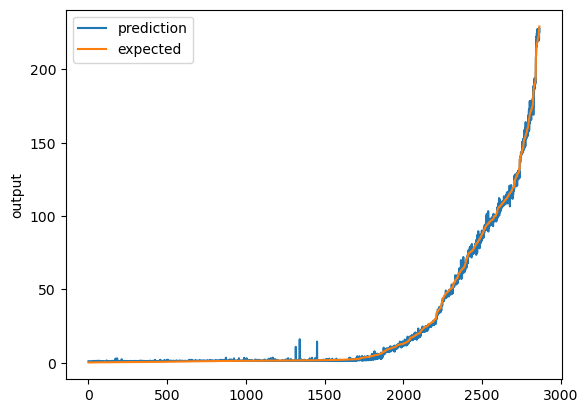

In [180]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_fcnn))
print("Test RMSE:", rmse)

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

chart_regression(y_pred_fcnn.flatten(), y_test, sort=True)


## Build the Convolutional Neural Network (CNN)

In [181]:
# Define the CNN model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

# input model (CNN with images)
visible = Input(shape=(7,5))
conv1 = Conv1D(128, kernel_size=3, activation='relu')(visible)
pool1 = MaxPooling1D(pool_size=2)(conv1)
drop1 = Dropout(0.2)(pool1)
flat = Flatten()(drop1)

# interpretation model
dense1 = Dense(64)(flat)
dense2 = Dense(32)(dense1)
output = Dense(1)(dense2)

# model creation
model_cnn = Model(inputs=visible, outputs=output)

# summarize layers
print(model_cnn.summary())

# Compile the model
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 7, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 5, 128)         │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,609 (80.50 KB)

 Trainable params: 20,609 (80.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [182]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Print training completion
print("CNN model training complete.")


Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 908.8264 - val_loss: 14.9350
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.3501 - val_loss: 4.5384
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.8589 - val_loss: 3.7220
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9514 - val_loss: 2.7304
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4879 - val_loss: 3.8097
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6638 - val_loss: 2.5406
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3654 - val_loss: 2.6626
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2590 - val_loss: 2.7874
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2378 - val_loss: 3.7986
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4555 - val_loss: 5.4959
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6608 - val_loss: 5.4572
CNN model training complete.


In [183]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on the test set
y_pred_cnn = model_cnn.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
print(f"Root Mean Square Error (RMSE): {rmse}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
Root Mean Square Error (RMSE): 1.5939250425437874


Test RMSE: 1.5939250425437874


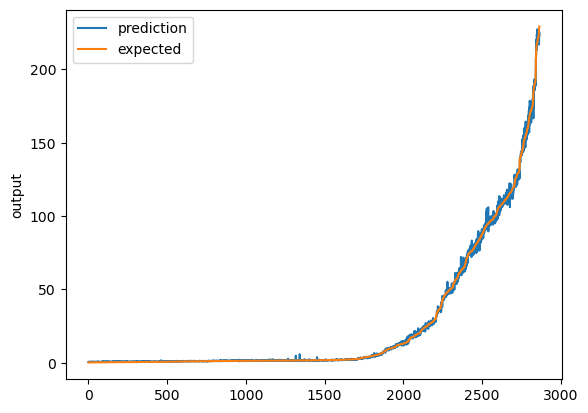

In [184]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
print("Test RMSE:", rmse)

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

chart_regression(y_pred_cnn.flatten(), y_test, sort=True)

## Build the Long Short-Term Memory Model (LSTM)

In [185]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the FCNN model
model_lstm = Sequential([
    LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=(7, 5)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with a single neuron for regression
])

print(model_lstm.summary())

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,769 (284.25 KB)

 Trainable params: 72,769 (284.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [186]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Print training completion
print("LSTM model training complete.")


Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1496.7994 - val_loss: 21.1112
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82.1516 - val_loss: 204.4848
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.4801 - val_loss: 148.0024
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.7335 - val_loss: 60.9282
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.2029 - val_loss: 118.4691
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.7706 - val_loss: 78.8884
LSTM model training complete.


In [187]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on the test set
y_pred_lstm = model_lstm.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
print(f"Root Mean Square Error (RMSE): {rmse}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Root Mean Square Error (RMSE): 4.594687041934837


Test RMSE: 4.594687041934837


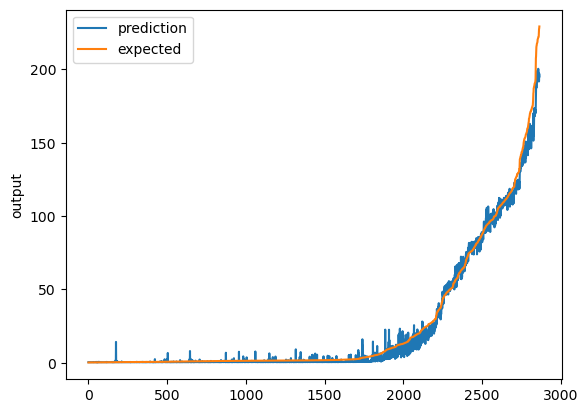

In [188]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
print("Test RMSE:", rmse)

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

chart_regression(y_pred_lstm.flatten(), y_test, sort=True)